In [2]:
import gzip
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm

In [3]:
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Conv2D, Activation, BatchNormalization, Add, Input, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from keras.datasets import cifar10
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import Callback, LearningRateScheduler
from tensorflow.keras.optimizers import SGD
from keras.regularizers import l2
from tensorflow.contrib.tpu.python.tpu import keras_support
import time, pickle, os

Using TensorFlow backend.


In [54]:
# http://yann.lecun.com/exdb/mnist/

with gzip.open('./data/train-images-idx3-ubyte.gz', 'rb') as f:
    train_x = np.frombuffer(f.read(), np.uint8, offset=16)
    train_x = train_x.reshape(60000, 28, 28)
    
with gzip.open('./data/t10k-images-idx3-ubyte.gz', 'rb') as f:
    valid_x = np.frombuffer(f.read(), np.uint8, offset=16)
    valid_x = valid_x.reshape(10000, 28, 28)

with gzip.open('./data/train-labels-idx1-ubyte.gz', 'rb') as f:
    train_y = np.frombuffer(f.read(), np.uint8, offset=8)
    
with gzip.open('./data/t10k-labels-idx1-ubyte.gz', 'rb') as f:
    valid_y = np.frombuffer(f.read(), np.uint8, offset=8)
    
train_sample_index = np.random.choice(60000, size=10)
train_x_sample = train_x[train_sample_index, :, :]
train_y_sample = train_y[train_sample_index]
valid_sample_index = np.random.choice(10000, size=1)
valid_x_sample = valid_x[valid_sample_index, :, :]
valid_y_sample = valid_y[valid_sample_index]

train_x_sample.shape, train_y_sample.shape, valid_x_sample.shape, valid_y_sample.shape

((10, 28, 28), (10,), (1, 28, 28), (1,))

In [55]:
def to_rgb(x):
    
    w, h = x.shape
    ret = np.empty((w, h, 3), dtype=np.uint8)
    ret[:, :, 0] = x
    ret[:, :, 1] = x
    ret[:, :, 2] = x
    
    return ret

In [56]:
train_x_sample = np.array([to_rgb(x) for x in train_x_sample])
valid_x_sample = np.array([to_rgb(x) for x in valid_x_sample])

train_x_sample.shape, valid_x_sample.shape

((10, 28, 28, 3), (1, 28, 28, 3))

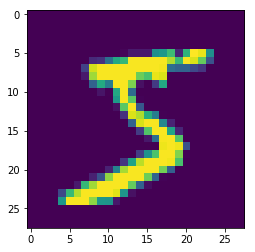

In [57]:
x = train_x[0]

plt.imshow(x)
plt.show()

In [58]:
class TimeHistory(Callback):
    
    def on_train_begin(self, logs={}):
        
        self.times = []

    def on_epoch_begin(self, epoch, logs={}):
        
        self.epoch_start_time = time.time()

    def on_epoch_end(self, epoch, logs={}):
        
        self.times.append(time.time() - self.epoch_start_time)

In [61]:
class ResNet:
    
    def __init__(self, n, framework, initial_lr=0.01, nb_epochs=100):
        
        self.n = n
        # バッチサイズがかなり違うので学習率は要調整
        self.framework = framework
        self.initial_lr = initial_lr
        self.nb_epochs = nb_epochs
        self.batch_size = 1
        self.weight_decay = 0.0005
        # Make model
        self.model = self.make_model()

    # オリジナルの論文に従って、サブサンプリングにPoolingではなくstride=2のConvを使う
    def subsumpling(self, output_channels, input_tensor):
        
        return Conv2D(output_channels, kernel_size=1, strides=(2,2), kernel_regularizer=l2(self.weight_decay))(input_tensor)

    # BN->ReLU->Conv->BN->ReLU->Conv をショートカットさせる(Kaimingらの研究による)
    # https://www.slideshare.net/KotaNagasato/resnet-82940994
    def block(self, channles, input_tensor):
        
        # ショートカット元
        shortcut = input_tensor
        # メイン側
        x = BatchNormalization()(input_tensor)
        x = Activation("relu")(x)
        x = Conv2D(channles, kernel_size=3, padding="same", kernel_regularizer=l2(self.weight_decay))(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        x = Conv2D(channles, kernel_size=3, padding="same", kernel_regularizer=l2(self.weight_decay))(x)
        # 結合
        return Add()([x, shortcut])

    def make_model(self):
        
        input = Input(shape=(32, 32, 3))
        # 3->16にチャンネル数を増やす
        x = Conv2D(16, kernel_size=3, padding="same", kernel_regularizer=l2(self.weight_decay))(input)
        # 32x32x16のブロックをn回
        for i in range(self.n):
            x = self.block(16, x)
        # 16x16x32
        x = self.subsumpling(32, x)
        for i in range(self.n):
            x = self.block(32, x)
        # 8x8x64
        x = self.subsumpling(64, x)
        for i in range(self.n):
            x = self.block(64, x)
        # Global Average Pooling
        x = GlobalAveragePooling2D()(x)
        x = Dense(10, activation="softmax")(x)
        # model
        model = Model(input, x)
        return model

    def lr_schduler(self, epoch):
        
        x = self.initial_lr
        if epoch >= self.nb_epochs * 0.5: x /= 10.0
        if epoch >= self.nb_epochs * 0.75: x /= 10.0
        return x

    def train(self, X_train, y_train, X_val, y_val):
        
        # コンパイル
        self.model.compile(optimizer=SGD(lr=self.initial_lr, momentum=0.9), loss="categorical_crossentropy", metrics=["acc"])
        # Data Augmentation
        traingen = ImageDataGenerator(rescale=1./255, width_shift_range=4./32, height_shift_range=4./32, horizontal_flip=True)
        valgen = ImageDataGenerator(rescale=1./255)
        """
        # TPU
        tpu_grpc_url = "grpc://"+os.environ["COLAB_TPU_ADDR"]
        tpu_cluster_resolver = tf.contrib.cluster_resolver.TPUClusterResolver(tpu_grpc_url)
        strategy = keras_support.TPUDistributionStrategy(tpu_cluster_resolver)
        self.model = tf.contrib.tpu.keras_to_tpu_model(self.model, strategy=strategy)
        """
        # Callback
        time_cb = TimeHistory()
        lr_cb = LearningRateScheduler(self.lr_schduler)
        # Train
        history = self.model.fit_generator(traingen.flow(X_train, y_train, batch_size=self.batch_size), epochs=self.nb_epochs,
                                           steps_per_epoch=len(X_train)/self.batch_size, validation_data=valgen.flow(X_val, y_val, batch_size=self.batch_size),
                                           validation_steps=len(X_val)/self.batch_size,
                                           callbacks=[time_cb, lr_cb]).history
        history["time"] = time_cb.times
        # Save history
        file_name = f"{self.framework}_n{self.n}.dat"
        with open(file_name, "wb") as fp:
            pickle.dump(history, fp)

In [63]:
K.clear_session()
model = ResNet(3, 'tf_keras', nb_epochs=1)
#train_y, valid_y = to_categorical(train_y), to_categorical(valid_y) # to one-hot
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
y_train, y_test = to_categorical(y_train), to_categorical(y_test)
#model.train(train_x, train_y, valid_x, valid_y)
model.train(X_train, y_train, X_test, y_test)

170500096/170498071 [==============================] - 2832s 17us/step
Epoch 1/1
50000/50000 [==============================] - 2563s 51ms/step - loss: 14.5753 - acc: 0.0994 - val_loss: 14.5218 - val_acc: 0.1000


In [51]:
train_y2 = to_categorical(train_y)
train_y2

array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.]], dtype=float32)

In [52]:
train_y

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

In [53]:
train_y2[0]

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.], dtype=float32)